In [8]:
%load_ext autoreload
%autoreload 2
import astropy.units as u
import astropy.constants as const
from astroduet.duet_telescope import load_telescope_parameters
from astroduet.duet_sensitivity import src_rate, bgd_sky_qe_rate, bgd_electronics, calc_exposure, calc_snr
from astroduet.duet_neff import get_neff
from astroduet.bbmag import bb_abmag_fluence, bb_abmag, gettempbb
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['figure.figsize'] = [12,8]

In [3]:
# Telescope setup
read_noise = 3.*(2**0.5) # Read noise for two frames

point_drift = 1*u.arcsec # To be added to the PSF in quadrature
point_jitter = 5*u.arcsec
# Define bands
td1_band = [193, 233]*u.nm


# Transmission efficiency
trans_eff = (0.975)**8 # from Jim. 

print('Transmission efficiency: {}'.format(trans_eff))

# Load telescope info
config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)

area = np.pi * (diameter*0.5)**2
area_onaxis = np.pi * (0.5*24.2*u.cm)**2
efficiency = area_onaxis / area

print('Effective area (used) {}'.format(area*efficiency))



# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()

Transmission efficiency: 0.8166518036622619
Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective area (used) 459.9605804120816 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114



In [4]:
# Other settings and background computation
light=True
texp = 300*u.s

dist0 = 10*u.pc
dist = [50,100,200]*u.Mpc

ab_vega = 1.73 # AB-Vega offset for Swift magnitudes

# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))

bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))


center = 208
width = 53
bandone=[center - 0.5*width, center+0.5*width]*u.nm

center = 284
width = 68
bandtwo=[center - 0.5*width, center+0.5*width]*u.nm

/Users/mheida/software/miniconda2/envs/duet/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


In [5]:
# Blackbody settings
bbtab = Table([[1.e4, 2.e4, 5.e4, 1.e5, 2.e5]*u.K,np.zeros(5),np.zeros(5)], names=('temp','mag_D1','mag_D2'))
snr = np.arange(5,100)
stat_err = 2.5*np.log10(1.+1./snr)
sys_err = [0.05,0.1,0.2] # Random guess...

In [6]:
# Get blackbody magnitudes (scale is random)
for i, temp in enumerate(bbtab['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab['mag_D1'][i], bbtab['mag_D2'][i] = mag1, mag2

In [9]:
# Fit blackbody temperatures:
bbtemps = np.zeros([len(sys_err),len(bbtab['temp']),len(snr),2])*u.K
for k, syserr in enumerate(sys_err):
    for i,temp in enumerate(bbtab['temp']):
        for j,staterr in enumerate(stat_err):
            fittemp, fittemperr = gettempbb(bandone=bandone, bandtwo=bandtwo,
                                        magone=bbtab['mag_D1'][i]*u.ABmag, magtwo=bbtab['mag_D2'][i]*u.ABmag,
                                        magone_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        magtwo_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag, bbtemp_init=temp)
            bbtemps[k,i,j] = fittemp, fittemperr

In [14]:
# DUET colors as function of temperature
bbtab_large = Table([np.geomspace(5e3,5e5,num=100)*u.K,np.zeros(100),np.zeros(100),np.zeros(100)], names=('temp','mag_D1','mag_D2','deltamag'))
for i, temp in enumerate(bbtab_large['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab_large['mag_D1'][i], bbtab_large['mag_D2'][i], bbtab_large['deltamag'][i] = mag1, mag2, mag1-mag2

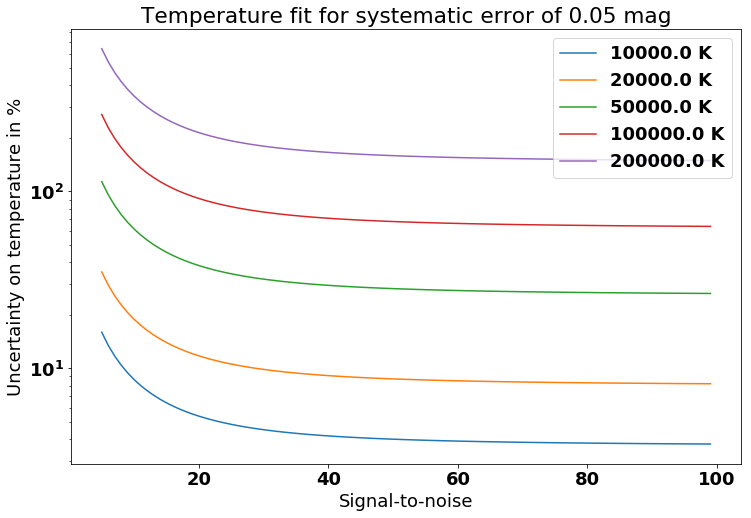

In [15]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[0,i,:,1]/bbtemps[0,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Uncertainty on temperature in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.05 mag')
plt.show()

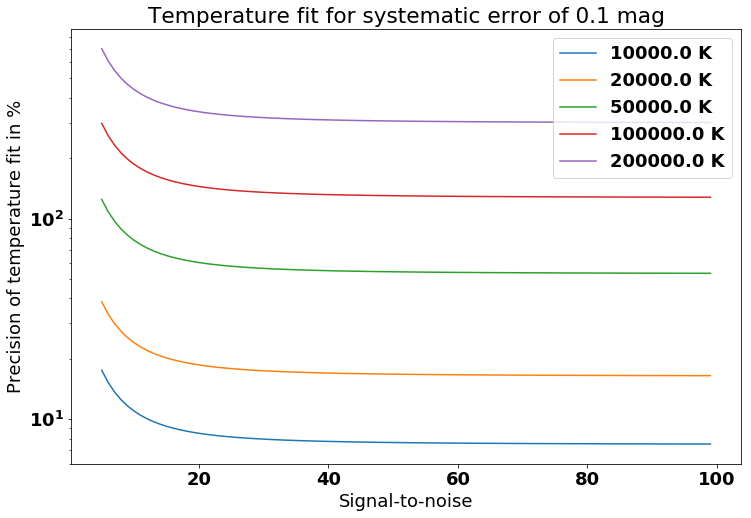

In [16]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[1,i,:,1]/bbtemps[1,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.1 mag')
plt.show()

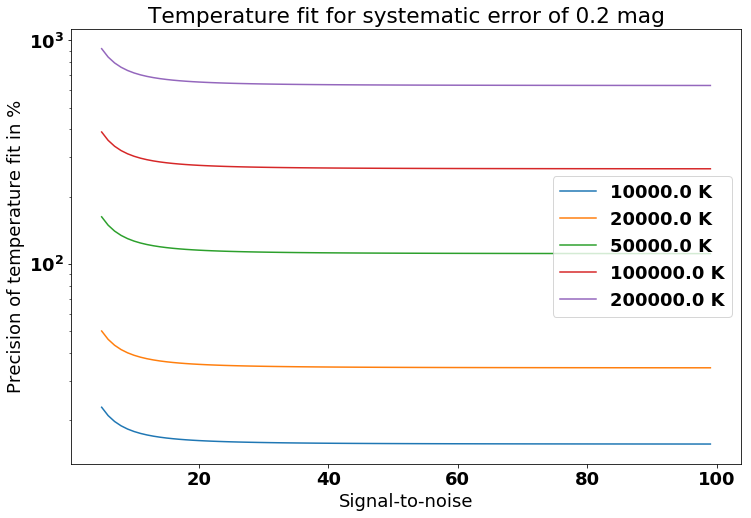

In [17]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[2,i,:,1]/bbtemps[2,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.2 mag')
plt.show()

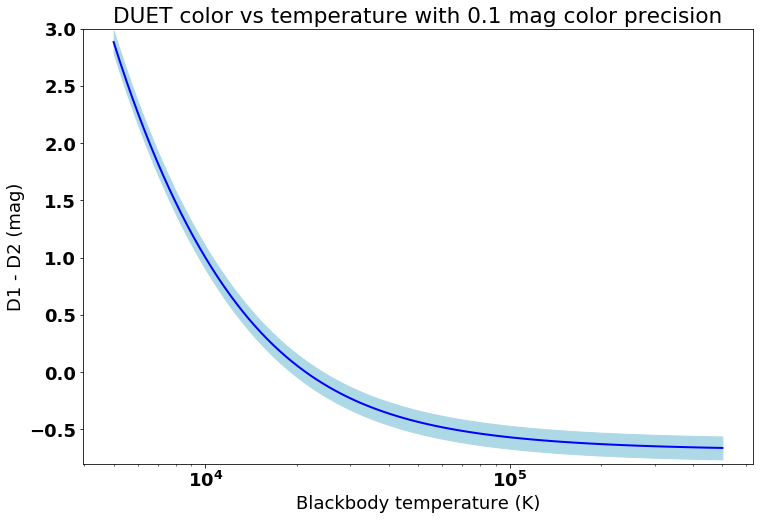

In [18]:
plt.fill_between(bbtab_large['temp'], bbtab_large['deltamag']-0.1, bbtab_large['deltamag']+0.1, color='lightblue')
plt.plot(bbtab_large['temp'],bbtab_large['deltamag'],linewidth=2, color='blue')

plt.xlabel('Blackbody temperature (K)')
plt.ylabel('D1 - D2 (mag)')
plt.ylim(-0.8,3)
#plt.xlim(1e4,5e5)
plt.xscale('log')
plt.title('DUET color vs temperature with 0.1 mag color precision')
plt.show()